## Finite-Volume Method (FVM)



* FVM discretizations are very general and have no requirement that the grid be structured, like in the finite-difference method. This makes FVM very flexible.
* FVM gives a conservative discretization automatically by using directly the conservation laws in integral form.

### Conservative Discretization
The law of conservation of mass says that the rate of change of mass in the control volume, plus the net rate of flow of mass across the control surfaces must be zero. The amount crossing the boundary is the flux. 

A general conservation law for a quantity e is thus:
$$
\frac{\partial}{\partial t}\int_{\text{cv}}e \, dV + \oint_{\text{cs}}\vec{F}\cdot d\vec{A} =0
$$
where $\vec{F}$ is the flux.

Imagine that the one-dimensional domain of interest is divided using grid points $x_i$. 
But instead of trying to compute local values at the grid points, we now want to follow the time evolution of average values within each one-dimensional cell of width $\Delta x$ with center at $x_i$.
As long as the cells are small enough, the average values will be a good representation of the quantities we are interested in.

Define $e_i$ as the integral average across the little control volume on the cell with center at $x_i$:
$$
e_i = \frac{1}{\Delta x} \int_{x_i - \Delta x / 2}^{x_i + \Delta x / 2} e(x, t) \, dx.
$$

If we know the flux terms at the boundaries of the control volume, which are at $x_{i-1/2}$ and $x_{i+1/2}$, the general conservation law for this small control volume gives:
$$
\frac{\partial}{\partial t} e_i + \frac{1}{\Delta x} \left[ F \left( x_{i+1/2}, t \right) - F \left( x_{i - 1 / 2}, t \right) \right] = 0.
$$


### Godunov's Method
For each control surface, we have two values for the solution $e$ at a given time: 
 1. the constant value to the left, $e_L$, and 
 2. the constant value to the right, $e_R$.
 
A situation where you have a conservation law with a constant initial condition, except for a single jump discontinuity is called a **Riemann problem**.
The Riemann problem has an exact solution for the Euler equations (as well as for any scalar conservation law).

We need to solve many Riemann problems from $t$ to $t + \Delta t$, one on each cell boundary (illustrated in Figure 4). The numerical flux on $x_{i+1/2}$ is 

$$
F_{i+1/2}= \frac{1}{\Delta t} \int_{t^n}^{t^{n+1}} F\left(e(x_{i+1/2},t) \right)\,dt
$$

To be able to solve each Riemann problem independently, they should not interact, which imposes a limit on $\Delta t$. 
$$
F_{i+1/2}= \frac{1}{2} \left( F \left( e_{i} \right) + F \left( e_{i+1} \right) - \frac{\Delta x}{\Delta t} \left( e_{i+1} - e_{i} \right) \right)
$$

In [1]:
import numpy
from matplotlib import pyplot, animation
from IPython.display import HTML
%matplotlib inline

In [2]:
# set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
from traffic import rho_red_light, flux

In [4]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(x, rho_max)
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as a 1D array of floats.



In [5]:
# set parameters
nx = 100  # number of cells along the road
L = 4.0  # length of the road
dx = L / nx  # cell width
nt = 30  # number of time steps to compute
rho_max = 10.0  # maximum traffic density allowed
u_max = 1.0  # speed limit

# get the grid-cell centers
# x_i is now the center of the i-th cell.
x = numpy.linspace(0.0 + 0.5 * dx, L - 0.5 * dx, num=nx)

# compute the initial traffic density
rho0 = rho_red_light(x, rho_max)

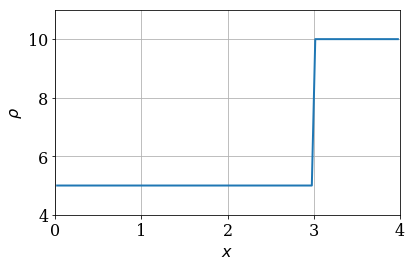

In [6]:
# plot the initial car density on the road
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout();

In [7]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes and returns the history of the traffic density on the road 
    using a Godunov scheme with a Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road as a 1D array of 
        floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_values : tuple or list
        The value of the density at the first and last locations as a 
        tuple or list of two floats
    args : list
        Positional arguments to be passed to the flux function
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road as a list of 1D 
        arrays of floats.
    """
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    
    for n in range(nt):
        rhoL = rho[:-1]  # i-th value at index i-1/2
        rhoR = rho[1:]  # i+1-th value at index i-1/2
        
        # compute the flux at cell boundaries
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args)
                   - dx / dt * (rhoR - rhoL))
        
        # advance in time
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        
        # apply boundary conditions
        rho[0], rho[-1] = bc_values
        
        # record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

In [8]:
# set time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [9]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution
    """
    
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [10]:
# create an animation of the traffic density
anim = animation.FuncAnimation(
    fig, update_plot, frames=nt, fargs=(rho_hist,), interval=100)

# display the video
HTML(anim.to_html5_video())

### Monotonic Upstream-Centered Scheme for Conservation Laws (MUSCL) Schemes

Godunov's scheme is first-order accurate, which is not accurate for hyperbolic conservation laws due to high numerical diffiusion.


#### Reconstruction in Space
The piecewise linear reconstruction consists of representing the solution inside each cell with a straight line. Define the cell representation as follows:
$$
e(x) = e_i + \sigma_i (x - x_i).
$$
where $\sigma_i$ is the slope of the approximation within the cell, and $e_i$ is the Godunov cell average. 
The choice $\sigma_i=0$ gives Godunov's method.

Standard central differencing would give
$$
\sigma_i = \frac{e_{i+1} - e_{i-1}}{2 \Delta x}.
$$

But this can lead to oscillations near shocks. 
These *Gibbs oscillations* will always appear (according to Godunov's theorem) unless we use constant reconstruction. 
So we have to modify, or limit the slope, near shocks.
The easiest way to limit is to compute one-sided slopes:
$$
\Delta e^- = \frac{e_i - e_{i-1}}{\Delta x}, \quad \Delta e^+ = \frac{e_{i+1} - e_{i}}{\Delta x}.
$$

Now build the *minmod* slope
$$
\begin{align}
  \sigma_i & = \text{minmod}(\Delta e^-, \Delta e^+) \\
  & = \begin{cases} \min(\Delta e^-, \Delta e^+) & \text{ if } \Delta e^-, \Delta e^+ > 0 \\
  \max(\Delta e^-, \Delta e^+) & \text{ if } \Delta e^-, \Delta e^+ < 0 \\
 0 & \text{ if } \Delta e^- \cdot \Delta e^+ \leq 0
  \end{cases}
\end{align}
$$

That is, use the smallest one-sided slope in magnitude, unless the slopes have different sign, in which cases it uses the constant reconstruction (i.e., Godunov's method)

Once the minmod slope is calculated, we can use it to obtain the values at the interfaces between cells.

$$
\begin{align}
e^{R}_{i-1/2} &= e_i - \sigma_i \frac{\Delta x}{2}\\
e^{L}_{i+1/2} &= e_i + \sigma_i \frac{\Delta x}{2}
\end{align}
$$
where $e^R$ and $e^L$ are the local interpolated values of the conserved quantity immediately to the right and left of the cell boundary, respectively.

In [11]:
def minmod(e, dx):
    """
    Computes the minmod approximation of the slope.
    
    Parameters
    ----------
    e : list or numpy.ndarray
        The input values as a 1D array of floats
    dx : float
        The grid-cell width
    
    Returns
    -------
    sigma : numpy.ndarray
        The minmod-approximated slope as a 1D array of floats
    """
    
    sigma = numpy.zeros_like(e)
    
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i - 1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
            
    return sigma

### Evolution in Time

Since we are aiming for second-order accuracy in space, we might as well try for second-order in time, as well. We need a method to evolve the ordinary differential equation forwards in time:
$$
\frac{\partial}{\partial t} e_i + \frac{1}{\Delta x} \left[ F \left( x_{i+1/2}, t \right) - F \left( x_{i - 1 / 2}, t \right) \right] = 0
$$

A second-order Runge-Kutta method with special characteristics gives the following scheme:
\begin{align}
e^*_i & = e^n_i + \frac{\Delta t}{\Delta x}\left( F^n_{i-1/2} - F^n_{i+1/2} \right) \\
e^{n+1}_i & = \frac{1}{2} e^n_i + \frac{1}{2}\left( e^*_i + \frac{\Delta t}{\Delta x}\left( F^*_{i-1/2} - F^*_{i+1/2} \right) \right)
\end{align}

Armed with the interpolated values of $e$ at the cell boundaries we can generate a more accurate Rusanov flux. At cell boundary $i+1/2$, for example, this is:
$$
F_{i+1/2} = \frac{1}{2} \left( F \left( e^L_{i+1/2} \right) + F \left( e^R_{i+1/2} \right)   -  \frac{\Delta x}{\Delta t} \left( e^R_{i+1/2} - e^L_{i+1/2} \right) \right)
$$

In [12]:
def muscl(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes and returns the history of the traffic density on the road 
    using a MUSCL scheme with a minmod slope limiting and a 
    Lax-Friedrichs flux. The function uses a second-order Runge-Kutta 
    method to integrate in time.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road as a 1D array of 
        floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_values : tuple or list
        The value of the density at the first and last locations as a 
        tuple or list of two floats
    args : list
        Positional arguments to be passed to the flux function
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road as a list of 1D 
        array of floats
    """
    
    def compute_flux(rho):
        # compute the minmod slope
        sigma = minmod(rho, dx)
        
        # reconstruct values at cell boundaries
        rhoL = (rho + sigma * dx / 2.0)[:-1]
        rhoR = (rho - sigma * dx / 2.0)[1:]
        
        # compute the flux
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args)
                   - dx / dt * (rhoR - rhoL))
        
        return F
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    
    for n in range(nt):
        # compute the flux at cell boundaries
        F = compute_flux(rho)
        
        # perform 1st step of RK2
        rho_star[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        
        # apply boundary conditions
        rho_star[0], rho_star[-1] = bc_values
        
        # compute the flux at cell boundaries
        F = compute_flux(rho_star)
        
        # perform 2nd step of RK2
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1]
                           - dt / dx * (F[1:] - F[:-1]))
        
        # apply boundary conditions
        rho[0], rho[-1] = bc_values
        
        # record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

In [13]:
# set time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = muscl(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [14]:
# create an animation of the traffic density
anim = animation.FuncAnimation(
    fig, update_plot, frames=nt, fargs=(rho_hist,), interval=100)

# display the video
HTML(anim.to_html5_video())